<a href="https://colab.research.google.com/github/stsvetanov/Modern-a/blob/master/surface_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Import required libraries

In [ ]:
import numpy as np
import pandas as pd
import cv2
import requests
import matplotlib.pyplot as plt
import seaborn as sns # used for plot interactive graph
import seaborn as sns
import plotly.express as px
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
from pathlib import Path
from sklearn.model_selection import train_test_split

## Load and view the input data

In [ ]:
# from google.colab import files
# files.upload()

In [ ]:
# file_url = 'https://drive.google.com/uc?export=download&id=15gIMFzrmidrlEnK6ZyGniKFlrDze6Pr0&confirm=t' # 200x200 tiles
file_url = 'https://drive.google.com/uc?export=download&id=1LsTAQEZStWlPEYQIacHcqGvI-5T6ANnr&confirm=t' # 100x100 tiles
response = requests.get(file_url, stream=True)
open("archive.zip", "wb").write(response.content)

29152756

In [ ]:
!unzip -q "archive.zip"

In [ ]:
positive_dir = Path('Positive')
negative_dir = Path('Negative')

In [ ]:
def generate_df(image_dir, label):
    filepaths = pd.Series(list(image_dir.glob(r'*.png')), name='Filepath').astype(str)
    labels = pd.Series(label, name='Label', index=filepaths.index)
    df = pd.concat([filepaths, labels], axis=1)
    return df

In [ ]:
positive_df = generate_df(positive_dir, label="POSITIVE")
negative_df = generate_df(negative_dir, label="NEGATIVE")

df = pd.concat([positive_df, negative_df], axis=0).sample(frac=1.0, random_state=1).reset_index(drop=True)
df

,Filepath,Label
0,Positive/img_74_1200_1300.png,POSITIVE
1,Positive/img_78_300_800.png,POSITIVE
2,Positive/img_3_800_900.png,POSITIVE
3,Negative/img_85_1400_500.png,NEGATIVE
4,Positive/img_17_600_1800.png,POSITIVE
...,...,...
2559,Positive/img_60_1100_800.png,POSITIVE
2560,Positive/img_69_700_800.png,POSITIVE
2561,Positive/img_19_800_1900.png,POSITIVE
2562,Positive/img_5_700_600.png,POSITIVE


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


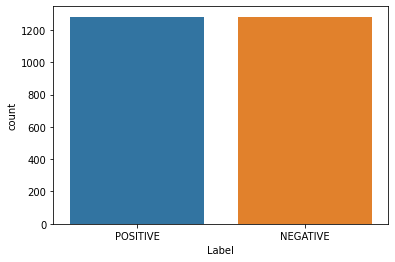

In [ ]:
sns.countplot(df['Label'],label="Count")

## Prepare the data

In [ ]:
train_df, test_df = train_test_split(df,train_size=0.7,shuffle=True,random_state=42)

In [ ]:
train_df.shape

(1794, 2)

In [ ]:
test_df.shape

(770, 2)

**Image Data Generator generates batches of tensor image data with real-time data augmentation.**

**For more insights check the tensorflow official documentation https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator**

In [ ]:
train_gen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255,validation_split=0.2,
    featurewise_center=True,
    featurewise_std_normalization=True,
    zca_whitening=False,
    zca_epsilon=1e-06,
    rotation_range=20,
    width_shift_range=0.0,
    height_shift_range=0.0,
    brightness_range=None,
    shear_range=0.0,
    fill_mode='nearest',
    cval=0.0,
    horizontal_flip=True,
    vertical_flip=True,
    preprocessing_function=None,
    data_format=None,
    interpolation_order=1,
    dtype=None)

test_gen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

**flow_from_dataframe checks the path available on the dataframe and then automatically search for the image in train directory. Then it make the desired preprocessing steps available in ImageDataGenerator**

**More insights can be found from this article https://vijayabhaskar96.medium.com/tutorial-on-keras-imagedatagenerator-with-flow-from-dataframe-8bd5776e45c1**

In [ ]:
batch_size = 32
target_size = (100, 100)

In [ ]:
train_data = train_gen.flow_from_dataframe(
    train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=target_size,
    color_mode='rgb',
    class_mode='binary',
    batch_size=batch_size,
    shuffle=True,
    seed=42,
    subset='training')

Found 1436 validated image filenames belonging to 2 classes.


In [ ]:
val_data = train_gen.flow_from_dataframe(
    train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=target_size,
    color_mode='rgb',
    class_mode='binary',
    batch_size=batch_size,
    shuffle=True,
    seed=42,
    subset='validation')

Found 358 validated image filenames belonging to 2 classes.


In [ ]:
test_data = train_gen.flow_from_dataframe(
    test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=target_size,
    color_mode='rgb',
    class_mode='binary',
    batch_size=32,
    shuffle=False,
    seed=42)

Found 770 validated image filenames belonging to 2 classes.


In [ ]:
test_data.class_indices

{'NEGATIVE': 0, 'POSITIVE': 1}

/usr/local/lib/python3.7/dist-packages/keras/preprocessing/image.py:1663: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.7/dist-packages/keras/preprocessing/image.py:1671: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


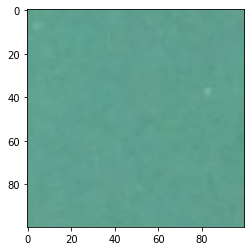

In [ ]:
image, label = next(iter(train_data))
plt.imshow(image[0])

## Create the model

In [ ]:
# inputs = tf.keras.Input(shape=(120, 120, 3))
# inputs = tf.keras.Input(shape=(200, 200, 3))
inputs = tf.keras.Input(shape=(100, 100, 3))
x = tf.keras.layers.Conv2D(filters=16, kernel_size=(3, 3), activation='relu')(inputs)
x = tf.keras.layers.MaxPool2D(pool_size=(2, 2))(x)
x = tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu')(x)
x = tf.keras.layers.MaxPool2D(pool_size=(2, 2))(x)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

# opt = tf.keras.optimizers.Adam(learning_rate=1e-06)
model.compile(
    optimizer='adam',
#     optimazer=opt,
    loss='binary_crossentropy',
    metrics=['accuracy'])
print(model.summary())

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 100, 100, 3)]     0         
                                                                 
 conv2d_2 (Conv2D)           (None, 98, 98, 16)        448       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 49, 49, 16)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 47, 47, 32)        4640      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 23, 23, 32)       0         
 2D)                                                             
                                                                 
 global_average_pooling2d_1   (None, 32)               0   

## Fitting the model

In [ ]:
history = model.fit(train_data,validation_data=val_data,epochs=20,
            callbacks=[tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=5,
            restore_best_weights=True)])

Epoch 1/20
45/45 [==============================] - 11s 236ms/step - loss: 0.6948 - accuracy: 0.5007 - val_loss: 0.6918 - val_accuracy: 0.5196
Epoch 2/20
45/45 [==============================] - 10s 232ms/step - loss: 0.6935 - accuracy: 0.4923 - val_loss: 0.6914 - val_accuracy: 0.5196
Epoch 3/20
45/45 [==============================] - 10s 230ms/step - loss: 0.6951 - accuracy: 0.4993 - val_loss: 0.6919 - val_accuracy: 0.5196
Epoch 4/20
45/45 [==============================] - 10s 229ms/step - loss: 0.6929 - accuracy: 0.5202 - val_loss: 0.6926 - val_accuracy: 0.4804
Epoch 5/20
45/45 [==============================] - 10s 231ms/step - loss: 0.6917 - accuracy: 0.5202 - val_loss: 0.6909 - val_accuracy: 0.5084
Epoch 6/20
45/45 [==============================] - 11s 232ms/step - loss: 0.6927 - accuracy: 0.5272 - val_loss: 0.6922 - val_accuracy: 0.4804
Epoch 7/20
45/45 [==============================] - 11s 240ms/step - loss: 0.6899 - accuracy: 0.5362 - val_loss: 0.6882 - val_accuracy: 0.5196

##Save and load the model

In [ ]:
# model.save('./crack_detection_model')

In [ ]:
# file_url = "https://drive.google.com/uc?export=download&id=1iq0p_wQHcpwvENpXZtamao3n-57hTR3i&confirm=t"
# response = requests.get(file_url, stream=True)
# open("model.h5", "wb").write(response.content)

# model = tf.keras.models.load_model("model.h5")

## Training history

In [ ]:
fig = px.line(
    history.history,
    y=['loss', 'val_loss'],
    labels={'index': "Epoch", 'value': "Loss"},
    title="Training and Validation Loss Over Time")
fig.show()

In [ ]:
fig = px.line(
    history.history,
    y=['accuracy', 'val_accuracy'],
    labels={'index': "Epoch", 'value': "Accuracy"},
    title="Training and Validation Accuracy Over Time")
fig.show()

In [ ]:
def evaluate_model(model, test_data):
    
    results = model.evaluate(test_data, verbose=0)
    loss = results[0]
    acc = results[1]
    
    print("    Test Loss: {:.5f}".format(loss))
    print("Test Accuracy: {:.2f}%".format(acc * 100))

## Evaluate the model

In [ ]:
evaluate_model(model, test_data)

/usr/local/lib/python3.7/dist-packages/keras/preprocessing/image.py:1663: UserWarning:

This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.

/usr/local/lib/python3.7/dist-packages/keras/preprocessing/image.py:1671: UserWarning:

This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.



    Test Loss: 0.14078
Test Accuracy: 95.32%


**Confusion Matrix**

25/25 [==============================] - 5s 168ms/step


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  """Entry point for launching an IPython kernel.


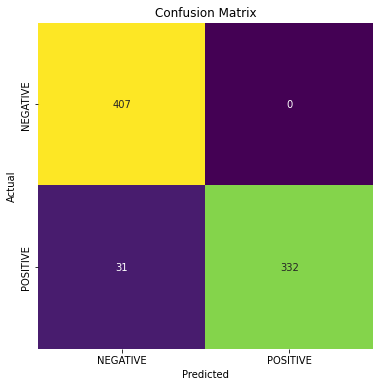

In [ ]:
y_pred = np.squeeze((model.predict(test_data) >= 0.5).astype(np.int))
cm = confusion_matrix(test_data.labels, y_pred)
clr = classification_report(test_data.labels, y_pred, target_names=["NEGATIVE", "POSITIVE"])
    
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='g', vmin=0, cmap='viridis', cbar=False)
plt.xticks(ticks=np.arange(2) + 0.5, labels=["NEGATIVE", "POSITIVE"])
plt.yticks(ticks=np.arange(2) + 0.5, labels=["NEGATIVE", "POSITIVE"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [ ]:
print("Classification Report:\n----------------------\n", clr)

Classification Report:
----------------------
               precision    recall  f1-score   support

    NEGATIVE       0.91      1.00      0.95       407
    POSITIVE       1.00      0.89      0.94       363

    accuracy                           0.95       770
   macro avg       0.96      0.95      0.95       770
weighted avg       0.95      0.95      0.95       770



## Run prediction on a single image

In [ ]:
img = cv2.imread('Positive/img_12_100_700.png')
img = cv2.resize(img, target_size)
result = model.predict(img[None])
print(result)
print(test_data.next()[0])

1/1 [==============================] - 0s 101ms/step
[[1.]]
[[[[0.5058824  0.67058825 0.6156863 ]
   [0.5058824  0.67058825 0.6156863 ]
   [0.51329523 0.6780011  0.62309915]
   ...
   [0.48376912 0.66808283 0.5974946 ]
   [0.4831134  0.6674271  0.5968389 ]
   [0.48245773 0.6667714  0.5961832 ]]

  [[0.5058824  0.67058825 0.6156863 ]
   [0.5058824  0.67058825 0.6156863 ]
   [0.5119839  0.67668974 0.6217878 ]
   ...
   [0.48970369 0.6740174  0.6034292 ]
   [0.49167076 0.6759845  0.6053963 ]
   [0.49363783 0.6779516  0.60736334]]

  [[0.5058824  0.67058825 0.6156863 ]
   [0.5058824  0.67058825 0.6156863 ]
   [0.51067245 0.6753783  0.62047637]
   ...
   [0.4965127  0.6808264  0.6102382 ]
   [0.49716842 0.68148214 0.6108939 ]
   [0.4978241  0.68213785 0.6115496 ]]

  ...

  [[0.5058824  0.67058825 0.62352943]
   [0.5058824  0.67058825 0.62352943]
   [0.5058824  0.67058825 0.62352943]
   ...
   [0.5167786  0.68148446 0.6265825 ]
   [0.518626   0.6833319  0.6284299 ]
   [0.51514167 0.67984754

/usr/local/lib/python3.7/dist-packages/keras/preprocessing/image.py:1663: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.7/dist-packages/keras/preprocessing/image.py:1671: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


In [ ]:
def predict_on_crops_serial(input_image, https=False, height=256, width=256, save_crops = False):
    
    if https:
        req = urllib.request.urlopen(input_image)
        arr = np.asarray(bytearray(req.read()), dtype=np.uint8)
        im = cv2.imdecode(arr, -1)
    elif isinstance(input_image, str):
        im = cv2.imread(input_image)
    else:
        im = input_image
        
    try:
        imgheight, imgwidth, channels = im.shape
    except:
        im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
        imgheight, imgwidth, channels = im.shape
        
    counter = 1
    output_image = np.zeros_like(im)
    
    
    for i in range(0,imgheight,height):
        for j in range(0,imgwidth,width):
            a = im[i:i+height, j:j+width]
     
#             a = np.expand_dims(a, axis=0)
#             processed_a = test2_datagen.flow(a).next()
             ## discard image cropss that are not full size
#             predicted_class = CLASSES[int(np.argmax(model.predict(processed_a), axis=-1))]

            result = model.predict(a[None], verbose = 0)

        
            if result[0] > 0.5:
                predicted_class = 'Positive'
            else:
                predicted_class = 'Negative'
            
            ## save image
#             file, ext = os.path.splitext(input_image)
#             image_name = file.split('/')[-1]
#             folder_name = 'out_' + image_name
            
            ## Put predicted class on the image
            if predicted_class == 'Positive':
                color = (0,0, 255)
            else:
                color = (0, 255, 0)
#             cv2.putText(a, predicted_class, (50,50), cv2.FONT_HERSHEY_SIMPLEX , 0.7, color, 1, cv2.LINE_AA) 
            b = np.zeros_like(a, dtype=np.uint8)
            b[:] = color
            add_img = cv2.addWeighted(a, 0.9, b, 0.1, 0, dtype=cv2.CV_64F)
            
            ## Save crops
            if save_crops:
                if not os.path.exists(os.path.join('predictions', folder_name)):
                    os.makedirs(os.path.join('predictions', folder_name))
                filename = os.path.join('predictions', folder_name,'img_{}.png'.format(counter))
                cv2.imwrite(filename, add_img)
            output_image[i:i+height, j:j+width,:] = add_img
            counter += 1
    ## Save output image
#     cv2.imwrite(os.path.join('predictions', folder_name+ '.jpg'), output_image)
    
    plt.figure(figsize=(10,10))
    plt.imshow(cv2.cvtColor(output_image, cv2.COLOR_BGR2RGB))

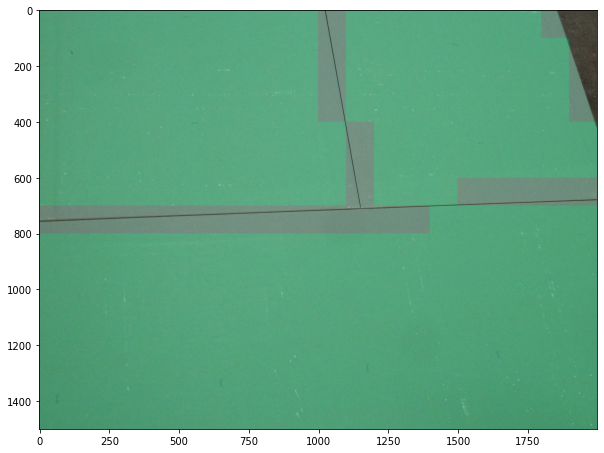

In [ ]:
# predict_on_crops_serial('2000x1500_10_resized.jpg', height=100, width=100)

In [ ]:
def generate_tiles(input_image, height=256, width=256):
        
    tiles = []
    tiles_position = []
    imgheight, imgwidth, channels = input_image.shape
    for i in range(0, imgheight, height):
        for j in range(0, imgwidth, width):
            tile = input_image[i:i+height, j:j+width]
            tiles.append(tile)
            tiles_position.append((i, j))
    return tiles, tiles_position

In [ ]:
# %%time
# image_path = '2000x1500_10_resized.jpg'
# input_image = cv2.imread(image_path) 
# tiles, _ = generate_tiles(input_image, height=100, width=100)

CPU times: user 44.5 ms, sys: 0 ns, total: 44.5 ms
Wall time: 52 ms


In [ ]:
# %%timeit
# results = model.predict(np.array(tiles), verbose = 0)

642 ms ± 48.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [ ]:
def draw_tiles_anotation(predictions, input_image, out, tiles, tiles_position, height, width):
    output_image = np.zeros_like(input_image)
    
    for index, tile in enumerate(tiles):     
        if predictions[index] > 0.5:
            color = (0,0, 255)
        else:
            color = (0, 255, 0)
        
        b = np.zeros_like(tile, dtype=np.uint8)
        b[:] = color
        add_img = cv2.addWeighted(tile, 0.9, b, 0.1, 0, dtype=cv2.CV_64F)
        i, j = tiles_position[index]
        output_image[i:i+height, j:j+width,:] = add_img

    if out:
        out.write(output_image)
    else:
        plt.figure(figsize=(10,10))
        plt.imshow(cv2.cvtColor(output_image, cv2.COLOR_BGR2RGB))

In [ ]:
def predict_on_crops(input_image, out, height=256, width=256):
    if isinstance(input_image, str):
        input_image = cv2.imread(input_image)
    tiles, tiles_position = generate_tiles(input_image, height, width)
    predictions = model.predict(np.array(tiles), verbose = 0)
    draw_tiles_anotation(predictions, input_image, out, tiles, tiles_position, height, width)

In [ ]:
# Load the image from URL
file_url = "https://drive.google.com/uc?export=download&id=1JveAFQUAzQ7SsKEnTBmBTdXZcxTMQtFw&confirm=t"
response = requests.get(file_url, stream=True)
open("2000x1500_10_resized.jpg", "wb").write(response.content)

578065

CPU times: user 1.46 s, sys: 53.3 ms, total: 1.52 s
Wall time: 1.01 s


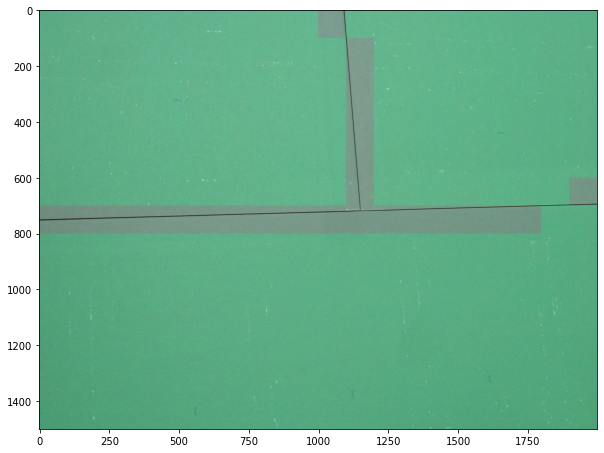

In [ ]:
%%time
predict_on_crops('2000x1500_10_resized.jpg', out=False, height=100, width=100)

## Test on video stream

In [ ]:
from imutils.video import FileVideoStream

In [ ]:
# Load the video file from URL
file_url = "https://drive.google.com/uc?export=download&id=16PefnId4cYOWZuXsP6drEQUpMx_iKtrE&confirm=t"
response = requests.get(file_url, stream=True)
open("drywall2.mp4", "wb").write(response.content)

7896900

In [ ]:
%%time
# cap = cv2.VideoCapture('/data/dataset/videos/drywall2.mp4')
fvs = FileVideoStream("drywall2.mp4").start()
out = cv2.VideoWriter('output.avi',cv2.VideoWriter_fourcc(*'MJPG'),30.0, (640,480))
# while(cap.isOpened()):
#     ret, frame = cap.read()
#     if ret==True:
#         predict_on_crops(frame, out, height=80, width=80)
#     else:
#         break
        
while fvs.more():
    frame = fvs.read()
    if frame is not None:
        predict_on_crops(frame, out, height=80, width=80)
    else:
        break

CPU times: user 7min 59s, sys: 12 s, total: 8min 11s
Wall time: 6min 24s
